# Проект "Прогнозирование рейтинга ресторана по данным сайта TripAdvisor"

In [1]:
# импорт библиотек и датасета
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# Зафиксируем RANDOM_SEED чтобы результаты прогнозирования были вопсроизводимы
RANDOM_SEED = 151

In [3]:
# Откроем исходный датафрейм по даннам сайта TripAdvisor
df = pd.read_csv('main_task.csv')

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

Restaurant_id — идентификационный номер ресторана;

City — город, в котором находится ресторан;

Cuisine Style — стиль или стили, к которым можно отнести блюда, предлагаемые в ресторане;

Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;

Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);

Price Range — диапазон цен в ресторане;

Number of Reviews — количество отзывов о ресторане;

Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;

URL_TA — URL страницы ресторана на TripAdvosor;

ID_TA — идентификатор ресторана в базе данных TripAdvisor

In [4]:
# Посмотрим на имеющиеся данные, их формат и количество пустых ячеек:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
34124,id_3154,Barcelona,"['Cafe', 'Spanish']",3155.0,4.0,NaN,17.0,"[['A good place for the short break', 'Nice qu...",/Restaurant_Review-g187497-d10840706-Reviews-E...,d10840706
33302,id_3216,Milan,['Italian'],3218.0,4.5,NaN,18.0,"[[], []]",/Restaurant_Review-g187849-d4053843-Reviews-Pi...,d4053843
12134,id_3239,Barcelona,"['Cafe', 'Mediterranean', 'European', 'Pizza',...",3240.0,4.0,$$ - $$$,64.0,"[['More than good', 'Healthy food'], ['08/16/2...",/Restaurant_Review-g187497-d7205454-Reviews-Me...,d7205454
342,id_12014,Paris,"['Seafood', 'Healthy']",12016.0,3.5,NaN,16.0,"[['good food, reasonable price, friendly staf....",/Restaurant_Review-g187147-d3735127-Reviews-Fi...,d3735127
36273,id_240,Prague,"['Grill', 'Armenian', 'Barbecue', 'Georgian', ...",241.0,5.0,$$ - $$$,63.0,"[['Nice lamp meat', 'Excellent Georgian food o...",/Restaurant_Review-g274707-d8078587-Reviews-U_...,d8078587


Итак, у нас всего 3 колонки с количественными данными, включая прогнозируемый столбец. Остальные представляют категориальные данные из которых нужно извлечь пользу для нашей модели.

# City

<AxesSubplot:xlabel='Rating', ylabel='City'>

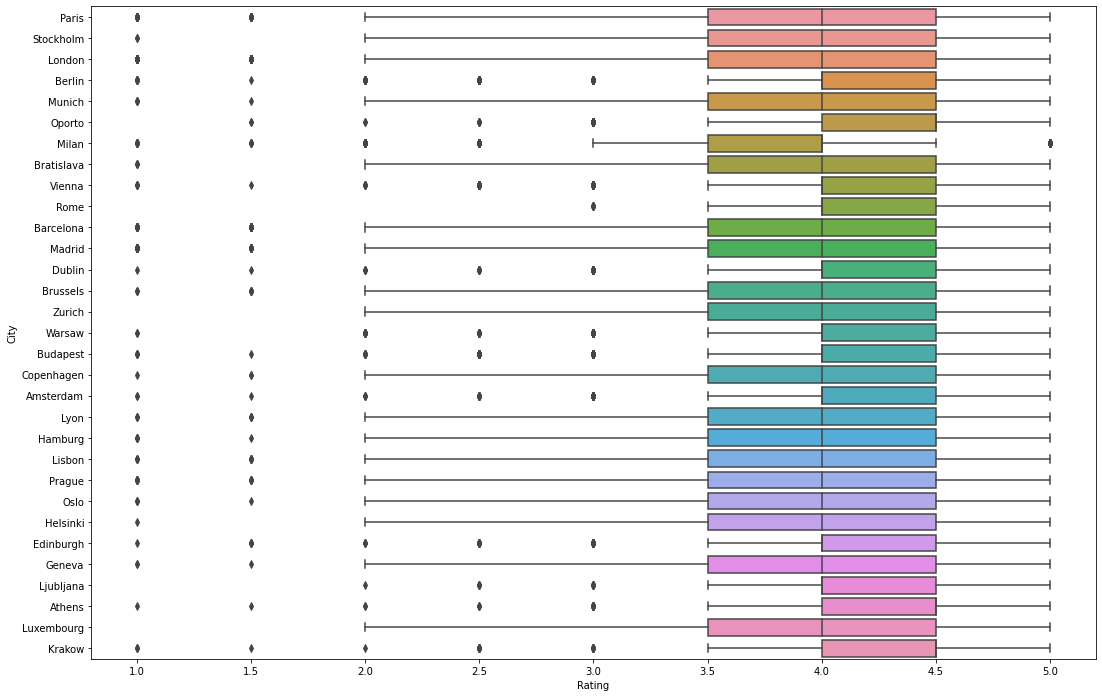

In [6]:
# Посмотрим на распределение целефой переменной относительно города
plt.figure(figsize=(18, 12))
sns.boxplot(x='Rating', y='City', data=df)

В некоторых городах оценки оценки расположены вплотную к 4-4,5 баллам и выбросы начинаются от 3,5 баллов и ниже

<AxesSubplot:>

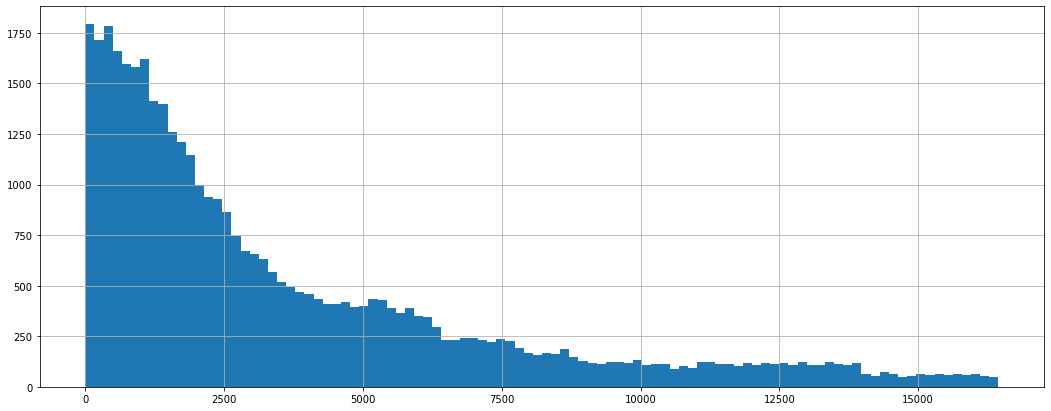

In [7]:
plt.rcParams['figure.figsize'] = (18,7)
df['Ranking'].hist(bins=100)

Признаки распределены неравномерно, большая часть ресторанов не дотягивает до 2500 места в своем городе, однако есть крупные города, в которых расположены более 15 000 ресторанов. Посмотрим на распределение:

<AxesSubplot:>

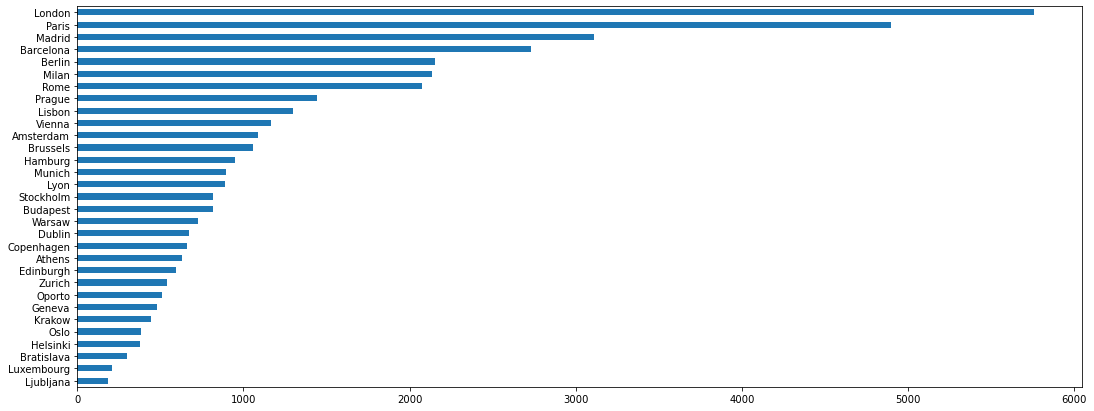

In [8]:
df['City'].value_counts(ascending=True).plot(kind='barh')

Всего в данных представлен 31 город. Большая часть ресторанов расположена в крупных городах, являющихся столицами. Создадим новый признак для нашей модели является ли город столицей:

In [9]:
# Создаем список столиц
List_capitals = ['Paris', 'Stockholm', 'London', 'Berlin', 'Bratislava', 'Vienna', 'Rome', 'Madrid', \
                 'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen', 'Amsterdam', 'Lisbon', 'Prague', 'Oslo', 'Helsinki', \
                'Edinburgh', 'Ljubljana', 'Athens', 'Luxembourg']

In [10]:
# Если город входит в список, то отмечаем как 1, если нет то 0
df.loc[df['City'].isin(List_capitals), 'Is_Capital'] = 1
df.loc[df['Is_Capital'].isnull(), 'Is_Capital'] = 0

In [11]:
# Посмотрим на количество ресторанов в столицах
df['Is_Capital'].value_counts()

1.0    30424
0.0     9576
Name: Is_Capital, dtype: int64

In [12]:
# Создадим копию столбца с городом, чтобы не потерять его при создании фиктивной переменной
df['City_copy'] = df['City']

In [13]:
# Создадим фиктивную переменную для города
df = pd.get_dummies(df, columns=[ 'City_copy'], dummy_na=True)

In [14]:
# Создадим признак количество ресторанов в городе.
city_counts_dict = dict(df['City'].value_counts())
df['rest_counts'] = df.City.map(city_counts_dict)
df['ranking_norm'] = df.Ranking / df.rest_counts

# Price Range

Price Range представляет из себя порядковую категориальную переменную, которую можно заменить на число:

In [15]:
df['Price Range'].replace({'$' : 1, '$$ - $$$': 2, '$$$$' : 3}, inplace = True)

In [16]:
# Создадим функцию, которая будет для указанной категории высчитывать медиану
def calc_mean(df,categ,calc):
    return df.groupby(categ)[calc].median()

In [17]:
# Посмотрим на медиану Price Range по горадам:
PR_Med_City = calc_mean(df,'City','Price Range')
PR_Med_City

City
Amsterdam     2.0
Athens        2.0
Barcelona     2.0
Berlin        2.0
Bratislava    2.0
Brussels      2.0
Budapest      2.0
Copenhagen    2.0
Dublin        2.0
Edinburgh     2.0
Geneva        2.0
Hamburg       2.0
Helsinki      2.0
Krakow        2.0
Lisbon        2.0
Ljubljana     2.0
London        2.0
Luxembourg    2.0
Lyon          2.0
Madrid        2.0
Milan         2.0
Munich        2.0
Oporto        2.0
Oslo          2.0
Paris         2.0
Prague        2.0
Rome          2.0
Stockholm     2.0
Vienna        2.0
Warsaw        2.0
Zurich        2.0
Name: Price Range, dtype: float64

Медиана во всех городах одинаковая и составила 2 (средний уровень цен)

In [18]:
# Заменим пустые значения на медиану (2)
df['Price Range'].fillna(2,inplace=True)

In [19]:
# Посмотрим количество ресторанов по Price Range
df['Price Range'].value_counts()

2.0    32298
1.0     6279
3.0     1423
Name: Price Range, dtype: int64

<AxesSubplot:xlabel='Price Range', ylabel='Rating'>

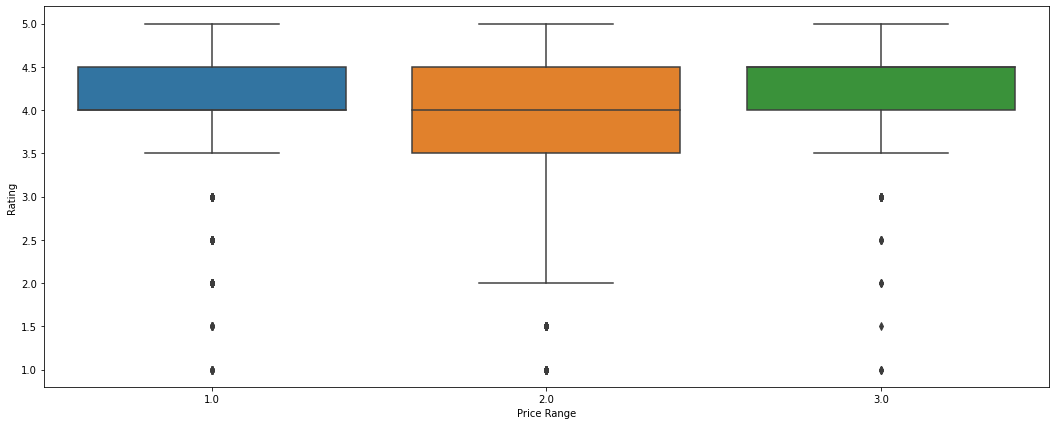

In [20]:
# Посмотрим на распределение рейтинга по ресторанам в зависимости от Price Range
sns.boxplot(x='Price Range', y='Rating', data=df)

# Cuisine Style

In [21]:
# Посмотрим на тип данных в Cuisine Style
type(df['Cuisine Style'][0])

str

В колонке Cuisine Style у нас представлены категории кухнь имеющиеся в ресторанах. Данные представляют собой строку

In [22]:
# Для каждого ресторана с непустым значением в Cuisine Style для мы преобразуем строку в список списков:
import ast
flat_list = []
for sublist in df[df['Cuisine Style'].notnull()]['Cuisine Style']:
    testarray = ast.literal_eval(sublist)
    flat_list.append(testarray)

In [23]:
# Заменим исходные данные 'Cuisine Style' на список
df.loc[df['Cuisine Style'].notnull(), 'Cuisine Style'] = flat_list

C:\Users\Grigory\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [24]:
# Пустые значения заменим на 'Other'
df.loc[df['Cuisine Style'].isnull(), 'Cuisine Style'] = 'Other'

In [25]:
# Создадим признак 'Количество кухонь'
df.loc[df['Cuisine Style'] != 'Other', 'Количество кухонь'] = [len(x) for x in df['Cuisine Style'] if x != 'Other']
df.loc[df['Cuisine Style'] == 'Other', 'Количество кухонь'] = 1

In [26]:
# Создадим список кухонь для создания признака популярности кухни 
list_of_coisine = [item for sublist in df[df['Cuisine Style'] != 'Other']['Cuisine Style'] for item in sublist]

<AxesSubplot:>

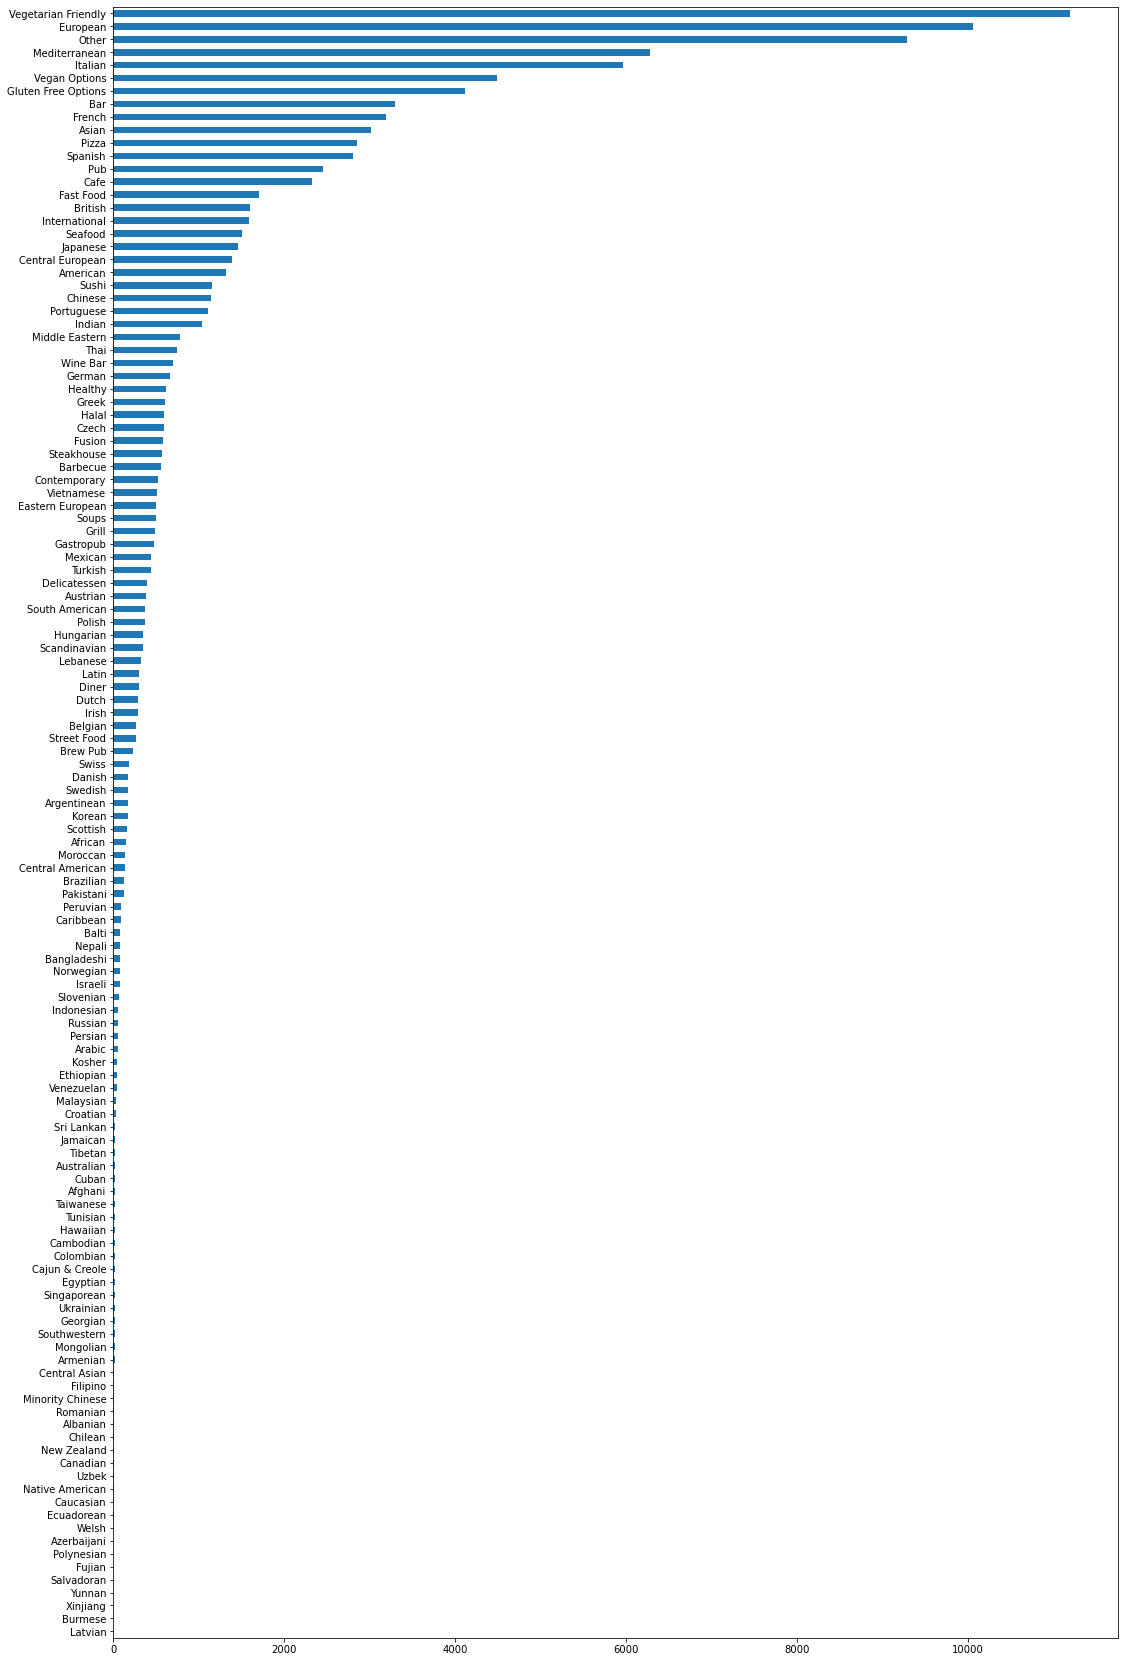

In [27]:
cuisine_lst = df.explode('Cuisine Style')['Cuisine Style'].value_counts(ascending=True)
plt.figure(figsize=(18,30))
cuisine_lst.plot(kind='barh')

In [28]:
# Посмотрим на количество кухонь в датасете
len(set(list_of_coisine))

125

У нас есть 125 кухнь, 14 из которых встречаются больше чем в 5% ресторанов

In [29]:
# Создадим словарь кухонь и количество ресторанов, в которых они представлены:
cuisine_lst_group = pd.Series((df.explode('Cuisine Style')['Cuisine Style']), index = (df.explode('Cuisine Style')['Cuisine Style']).index)
cuisine_lst_group = pd.DataFrame(cuisine_lst_group)
from collections import Counter
k = Counter(cuisine_lst_group['Cuisine Style'])

In [30]:
# Найдем первый и трений процентили в количестве ресторанов для кухнь
k = pd.DataFrame.from_dict(k, orient='index').reset_index()
x = np.percentile(k[0], 25)
l = np.percentile(k[0], 75)

In [31]:
# Создадим признак Rare_cousine, в котором отметим кухни, которые находятся ниже первого процентиля
k.loc[k[0] < x, 'Rare_cousine'] = 1
k.loc[k['Rare_cousine'].isnull(), 'Rare_cousine'] = 0

In [32]:
# Создадим признак Famous_cousine, в котором отметим кухни, которые находятся выше третьего процентиля
k.loc[k[0] >= l, 'Famous_cousine'] = 1
k.loc[k['Famous_cousine'].isnull(), 'Famous_cousine'] = 0

In [33]:
# Удалим лишний признак и переименуем колонку 'index' в 'Cuisine Style'
k.drop(labels=[0], axis = 1, inplace = True)
k = k.rename(columns = {'index' : 'Cuisine Style'})

In [34]:
# Добавим новые признаки к датафрему со списком кухнь 
cuisine_lst_group = cuisine_lst_group.reset_index()
cuisine_lst_group = cuisine_lst_group.merge(k, how = 'left', on = 'Cuisine Style')

In [35]:
# Для каждого ресторана посчитаем количество редких / популярных кухнь
count_coisine_by_popularity  = cuisine_lst_group.groupby('index')['Rare_cousine', 'Famous_cousine'].sum().reset_index()

C:\Users\62E1~1\AppData\Local\Temp/ipykernel_13976/2563832076.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  count_coisine_by_popularity  = cuisine_lst_group.groupby('index')['Rare_cousine', 'Famous_cousine'].sum().reset_index()


In [36]:
# Добавим к исходному датафрейму новые признаки
count_coisine_by_popularity.drop(labels=['index'], axis = 1, inplace = True)
df = df.merge(count_coisine_by_popularity, left_index = True, right_index = True)

In [37]:
# Создадим фиктивную переменную для Cuisine Style и добавим к нашим данным
cuisine_lst_group1 = cuisine_lst_group.groupby('index')['Cuisine Style'].apply(list).reset_index()
dummy_cousine = cuisine_lst_group1['Cuisine Style'].apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')
df = df.merge(dummy_cousine, left_index = True, right_index = True)    

# Restaurant_id

<AxesSubplot:xlabel='Price Range', ylabel='Rating'>

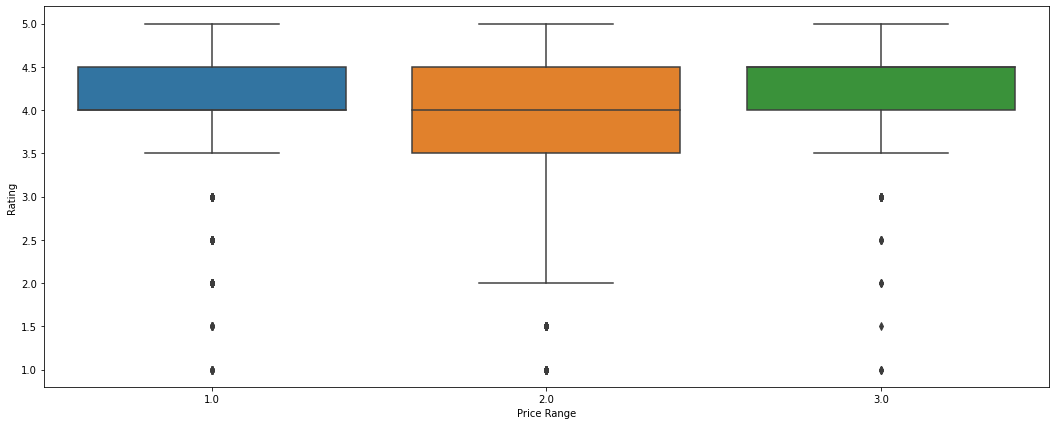

In [38]:
# Создадим признак 'chain', в котором будет отмечать 1 те рестораны, которые входят в сеть
chain_lst = list(df['Restaurant_id'].value_counts()[df['Restaurant_id'].value_counts() > 1].index)
df['chain'] = df[df['Restaurant_id'].isin(chain_lst)]['Restaurant_id'].apply(lambda x: 1)
df['chain'].fillna(0, inplace=True)
sns.boxplot(x='Price Range', y='Rating', data=df)

В среднем оценки ресторанов chain выше, чем независимых ресторанов, однако данные у нас неравномерные и выводы делать рано

In [39]:
df['chain'].value_counts()

1.0    35295
0.0     4705
Name: chain, dtype: int64

# Reviews

В колонке 'Reviews' тип данных str и значение представляет собой 2 последних отзыва и даты публикации этих отзывов:

In [40]:
print(df['Reviews'][0], type(df['Reviews'][0]))

[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']] <class 'str'>


In [41]:
# Создадим признак с датой последнего и предпоследнего отзыва воспользовавшись регулярными выражениями
import re
for index, item in enumerate(df['Reviews']):
    try:
        data = re.findall('\d+\/\d+\/\d+', item)
        df.loc[index, 'Дата последнего отзыва'] = data[0]
        df.loc[index, 'Дата предпоследнего отзыва'] = data[1]
    except Exception:
        continue

In [42]:
# Для пустых значений в 'Number of Reviews' будем отмечать 1, если есть 1 отзыв в 'Reviews' и 0, если отзывов нет
df.loc[(df['Number of Reviews'].isnull())&(df['Дата последнего отзыва'].isnull())&(df['Дата предпоследнего отзыва'].isnull()), 'Number of Reviews'] = 0
df.loc[(df['Number of Reviews'].isnull())&(df['Дата последнего отзыва'].notnull())&(df['Дата предпоследнего отзыва'].isnull()), 'Number of Reviews'] = 1

In [43]:
from datetime import datetime

In [44]:
# Конвертируем даты отзывов в формат datetime
df['Дата последнего отзыва'] = pd.to_datetime(df['Дата последнего отзыва'])
df['Дата предпоследнего отзыва'] = pd.to_datetime(df['Дата предпоследнего отзыва'])

In [45]:
# Заполним пропуски минимальным и максимальным значениями и создадим признак разницы в днях между отзывами
df['Дата предпоследнего отзыва'].fillna(df['Дата предпоследнего отзыва'].min(), inplace=True)
df['Дата последнего отзыва'].fillna(df['Дата последнего отзыва'].max(), inplace=True)
df['Разница между датами отзывов'] = abs(df['Дата предпоследнего отзыва'] - df['Дата последнего отзыва']).dt.days

In [46]:
# Создадим признак разницы в днях с сегодня
df['Разница с сегодня'] = (datetime.now() - df['Дата последнего отзыва']).dt.days

<AxesSubplot:>

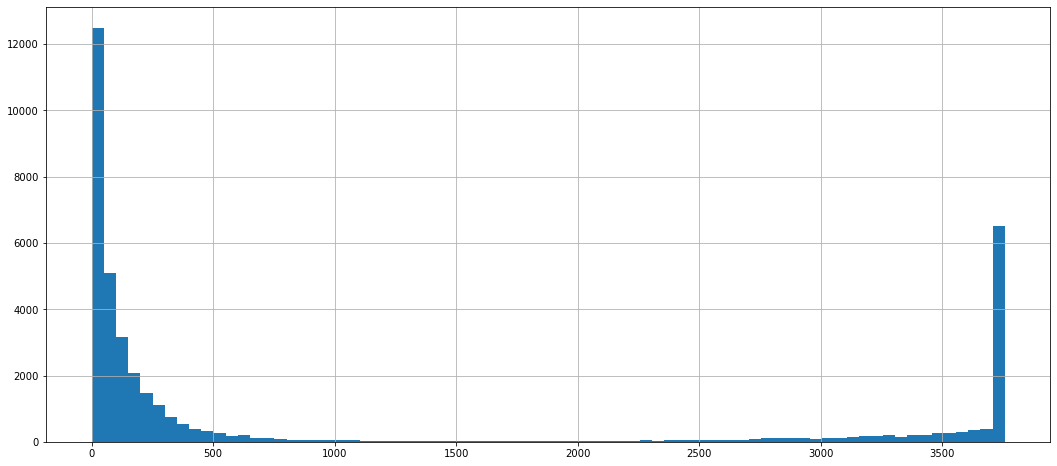

In [47]:
plt.figure(figsize=(18,8))
df['Разница между датами отзывов'].hist(bins=75)

In [48]:
# Удалим колонки с котегариальными данными и убедимся что у нас нет пустых значений в датафрейме
df = df.drop(labels= ['Restaurant_id', 'Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA', 'Дата последнего отзыва', 'Дата предпоследнего отзыва', 'City'], axis = 1)
for name in df.columns:
    print(name, df[name].isna().sum())

Ranking 0
Rating 0
Price Range 0
Number of Reviews 0
Is_Capital 0
City_copy_Amsterdam 0
City_copy_Athens 0
City_copy_Barcelona 0
City_copy_Berlin 0
City_copy_Bratislava 0
City_copy_Brussels 0
City_copy_Budapest 0
City_copy_Copenhagen 0
City_copy_Dublin 0
City_copy_Edinburgh 0
City_copy_Geneva 0
City_copy_Hamburg 0
City_copy_Helsinki 0
City_copy_Krakow 0
City_copy_Lisbon 0
City_copy_Ljubljana 0
City_copy_London 0
City_copy_Luxembourg 0
City_copy_Lyon 0
City_copy_Madrid 0
City_copy_Milan 0
City_copy_Munich 0
City_copy_Oporto 0
City_copy_Oslo 0
City_copy_Paris 0
City_copy_Prague 0
City_copy_Rome 0
City_copy_Stockholm 0
City_copy_Vienna 0
City_copy_Warsaw 0
City_copy_Zurich 0
City_copy_nan 0
rest_counts 0
ranking_norm 0
Количество кухонь 0
Rare_cousine 0
Famous_cousine 0
European 0
French 0
International 0
Other 0
Japanese 0
Sushi 0
Asian 0
Grill 0
Vegetarian Friendly 0
Vegan Options 0
Gluten Free Options 0
German 0
Central European 0
Italian 0
Pizza 0
Fast Food 0
Mediterranean 0
Spanish 0

<AxesSubplot:>

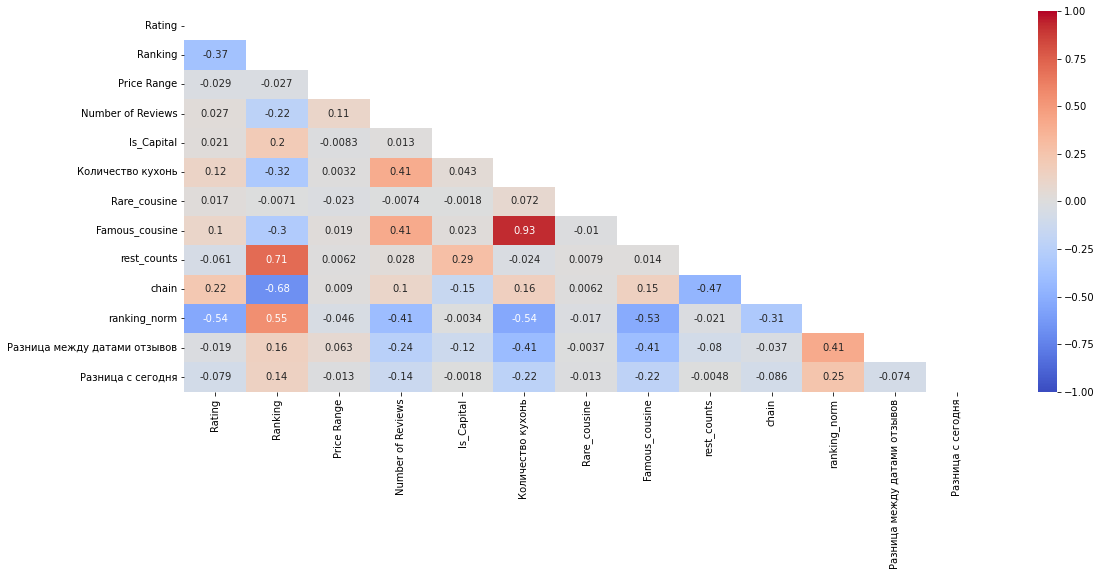

In [49]:
# Построим на матрицу корреляций (для лучшего восприятия уберем dummy переменные):
matrix = np.triu(df[['Rating', 'Ranking', 'Price Range', 'Number of Reviews', 'Is_Capital', 'Количество кухонь', 'Rare_cousine', 'Famous_cousine', 'rest_counts', 'chain', 'ranking_norm', 'Разница между датами отзывов', 'Разница с сегодня']].corr())
sns.heatmap(df[['Rating', 'Ranking', 'Price Range', 'Number of Reviews', 'Is_Capital', 'Количество кухонь', 'Rare_cousine', 'Famous_cousine', 'rest_counts', 'chain', 'ranking_norm', 'Разница между датами отзывов', 'Разница с сегодня']].corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)

Признак 'Famous_cousine' сильно скоррелирован с признаком 'Количество кухонь', можно его отбросить. Также можно убрать Ranking и оставить Runking_norm, т.к. он больше скоррелирован с целевой переменной

In [50]:
# Избавимся от лишних признаков
df = df.drop(labels= ['Famous_cousine', 'Ranking'], axis = 1)

In [51]:
# Разделим признаки и целевую переменную
X = df.drop(labels= 'Rating', axis = 1)
Y = df[['Rating']]

In [52]:
# Разделим выборку на тестовую и тренировочную часть
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9, random_state=RANDOM_SEED)

In [53]:
# Обучим линейную регрессию и будем использовать ее как baseline для более продвинутой
reg = LinearRegression(fit_intercept =True).fit(X_train, y_train)

In [54]:
# Предсказанные значения сохраним в ndarray
y_pred = reg.predict(X_test)

In [55]:
# Сравнивать модели будем с помощью метрики MAE
from sklearn import metrics
metrics.mean_absolute_error(y_test, y_pred)

0.35956301212031394

Линейная регрессия показала среднее абсолютное отклонение в 0.36 баллов

In [56]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [57]:
# Натренируем регрессор случайного леса
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, max_depth = 20, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\62E1~1\AppData\Local\Temp/ipykernel_13976/740336863.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [58]:
# Показатель MAE для случайного леса
metrics.mean_absolute_error(y_test, y_pred)

0.20252260148157125

Случайный лес справился с регрессией лучше линейной регрессии. Можно вывести самые важные признаки для модели:

<AxesSubplot:>

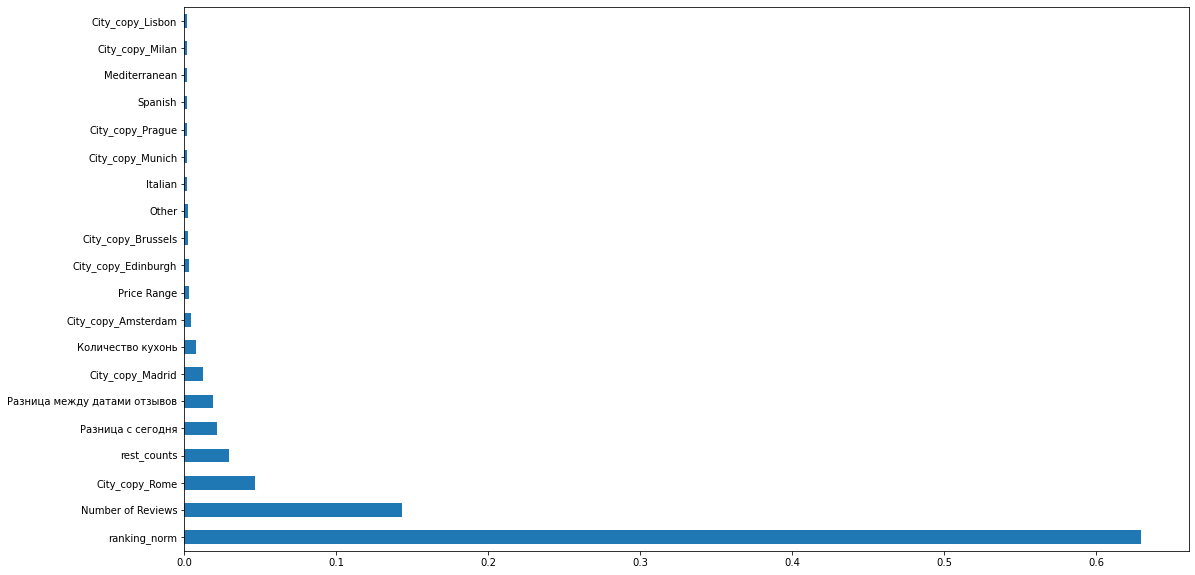

In [59]:
plt.rcParams['figure.figsize'] = (18,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# What's next?

Обработать оставшиеся признаки в понятный для машины формат

Посмотреть, что еще можно извлечь из признаков

Сгенерировать новые признаки

Подгрузить дополнительные данные, например: по населению или благосостоянию городов

Подобрать состав признаков